# Import Modules

In [1]:
import os
import sys
import numpy as np
import math
import xarray as xr
import pandas as pd
import wrf
from matplotlib import pyplot as plt
from matplotlib import gridspec
import json
plt.style.use('seaborn-white')

/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Load NetCDF From Cluster

In [2]:
scratch_folder_loc = '/p/lustre2/nainap/'
#netCDF_file_loc = os.path.join(scratch_folder_loc,'From_Pankaj', 'NetCDF_files','wrfout_chisholmView' )
netCDF_file_loc = os.path.join(scratch_folder_loc,'From_Pankaj', 'NetCDF_files','wrfout_GAD_FINO_SecondResult' )

In [3]:
netCDF_file_loc = '/p/lustre2/jha3/fromWill/FINO_MesoMicro_GAD_CPM/part5_output/tsout_d06_2010-05-16_00:00:10'

In [4]:
wrf_domain6 = xr.open_dataset(netCDF_file_loc)

In [5]:
#wrf_domain6

In [6]:
#wrf_domain6['UTS']

# Set-Up Variables for Contour Plots

In [7]:
def getQoI (netCDF_data, qoi):
    qoi_data = netCDF_data[qoi]
    qoi_dim_names = qoi_data.dims
    qoi_dim = qoi_data.shape
    
    #shape format in : [time, z, y, x]
    print('QoI: {}, \nDimension names: {}, \nDimensions: {} '.format(qoi, qoi_dim_names, qoi_dim))
    return qoi_data, qoi_dim_names, qoi_dim
    

### Provide desired time and location for contour plots

In [8]:
def sampling_loc_time(qoi_dim_names, qoi_dim):
    [time_dim, bottom_top_dim, south_north_dim, west_east_dim] = qoi_dim
    
    desired_time = [time_dim-1]
    #desired_time = list(np.arange(0, time_dim, 1))
    #hub_height = int(wrf_domain6['HUB_HEIGHT'].isel(Time=0)[0])
    hub_height = 100
    #bottom_top = [0.05*hub_height, 0.1*hub_height, 0.5*hub_height,hub_height] #bottom_top_locs
    bottom_top = [15,20,25]
    south_north = [int(west_east_dim*0.5), int(west_east_dim*0.75)] #south_north_locs
    west_east = [int(bottom_top_dim*0.25), int(south_north_dim*0.5), int(south_north_dim*0.75)] #west_east_locs

    #sampling location dictionary
    sampling_loc_time = '{"%s" : %s, "%s" : %s, "%s" : %s, "%s" : %s}'%(qoi_dim_names[0],desired_time, qoi_dim_names[1],bottom_top, qoi_dim_names[2], south_north, qoi_dim_names[3],west_east)
    slt = json.loads(sampling_loc_time)
    
    return slt

### Plot Contours

In [9]:
def contourPlot(qoi_data, plane_header, slt, plane_rows, plane_cols, pl):
    desired_time = slt['Time']
    print('Desired Time : {}'.format(desired_time))
    desired_space = slt[plane_header]
    print('Desired Space ({}) : {}'.format(plane_header, desired_space))
    qoi_time = [[]]
    for k in range(0,np.size(desired_time)):
        qoi_space = []
        for j in range(0,np.size(desired_space)):
            slice_loc = '{"%s" : %d}'%(plane_header, desired_space[j])
            slice_loc_dict = json.loads(slice_loc)
            arr = qoi_data.isel(Time=desired_time[k]).isel(slice_loc_dict)
            axes_name = arr.dims
            qoi_space.append(np.array(arr))
                    
        qoi_time.append(qoi_space)
       
    #print('qoi_time ', qoi_time)
    ncols = np.size(desired_space)    
    nrows = np.size(desired_time)
        
    cmap_name = 'rainbow'
     
    if nrows==1:
        fig = plt.figure(figsize = (20, 4))
        fig.subplots_adjust(hspace=0.2, wspace=0.25)
        #fig.figure(figsize = (20, 4))
        for i in range(ncols):
            time_inst_space = qoi_time[1]
            space = time_inst_space[i]
            x = int(round(np.shape(space)[0],-2))
            y = int(round(np.shape(space)[1],-2))
            ratio = y/x
            #print(ratio)
            ax = fig.add_subplot(nrows, ncols, i+1)
            fig.set_figheight(4*nrows)
            fig.set_figwidth(5*ncols*ratio)
            cont = ax.contourf(plane_cols,plane_rows, space, 20, cmap=cmap_name)
            clb = fig.colorbar(cont, ax=ax)
            clb.ax.set_title(f"%s [m/s]"%qoi, weight='bold')
            ax.set_xlabel(axes_name[1], fontsize=14)
            ax.set_ylabel(axes_name[0], fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.set_title(f"%s=%d, %s=%d" %('TimeIndex' ,desired_time[0], plane_header,desired_space[i]), fontsize=14)
            ax.set_xlim([250,350])
            ax.set_ylim([250,350])
        fig.tight_layout()
    else:
        fig, ax = plt.subplots(nrows, ncols, figsize = (20,4.5), sharex='col', sharey='row')#figsize = (20,4.5)
        fig.subplots_adjust(hspace=0.5, wspace=0.1)
    
        for l in range(nrows):
            time_inst_space = qoi_time[l+1]
            #ax.annotate(desired_time[l], textcoords='offset points',
                #size='large', ha='right', va='center')
            for m in range(ncols):
                space = time_inst_space[m]
                x = int(round(np.shape(space)[0],-2))
                y = int(round(np.shape(space)[1],-2))
                ratio = y/x
                #print(ratio)
                cont = ax[l,m].contourf(plane_cols,plane_rows, space, 20, cmap=cmap_name)
                clb = fig.colorbar(cont, ax=ax[l,m])
                clb.ax.set_title(f"%s [m/s]"%qoi, weight='bold')
                fig.set_figheight(4.5*nrows)#figsize = (4.5*nrows)
                fig.set_figwidth(5*ncols*ratio)
                ax[l,m].set_xlabel(axes_name[1], fontsize=14)
                ax[l,m].set_ylabel(axes_name[0], fontsize=14)
                ax[l,m].tick_params(axis='x', labelsize=14)
                ax[l,m].tick_params(axis='y', labelsize=14)
                ax[l,m].set_title(f"%s=%d, %s=%d" %('TimeIndex',desired_time[l], plane_header,desired_space[m]), fontsize=14)
                ax[l,m].set_xlim([250,350])
                ax[l,m].set_ylim([250,350])
        fig.tight_layout()
    
    filename = "%s-plane"%pl
    plt.savefig(filename, bbox_inches='tight')       
            

QoI: UTS, 
Dimension names: ('Time', 'bottom_top', 'south_north', 'west_east'), 
Dimensions: (60, 108, 600, 600) 
Desired Time : [59]
Desired Space (bottom_top) : [15, 20, 25]
QoI: TKETS, 
Dimension names: ('Time', 'bottom_top', 'south_north', 'west_east'), 
Dimensions: (60, 108, 600, 600) 
Desired Time : [59]
Desired Space (bottom_top) : [15, 20, 25]
QoI: T12TS, 
Dimension names: ('Time', 'bottom_top', 'south_north', 'west_east'), 
Dimensions: (60, 108, 600, 600) 
Desired Time : [59]
Desired Space (bottom_top) : [15, 20, 25]


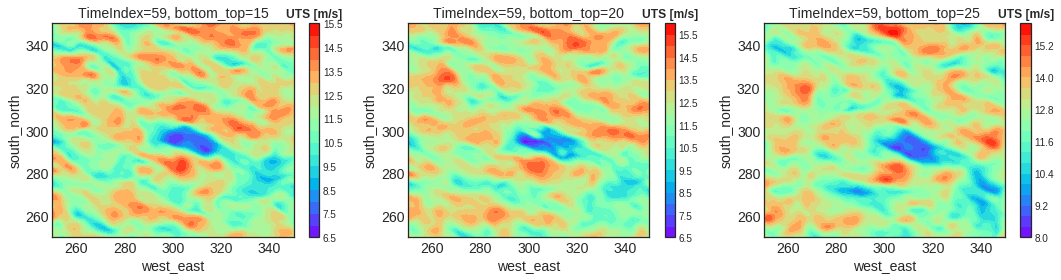

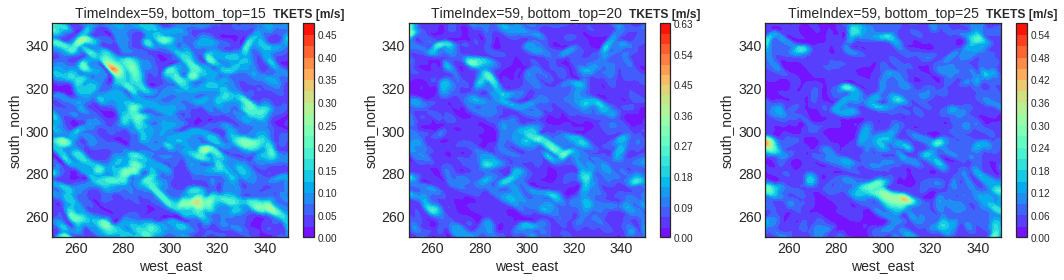

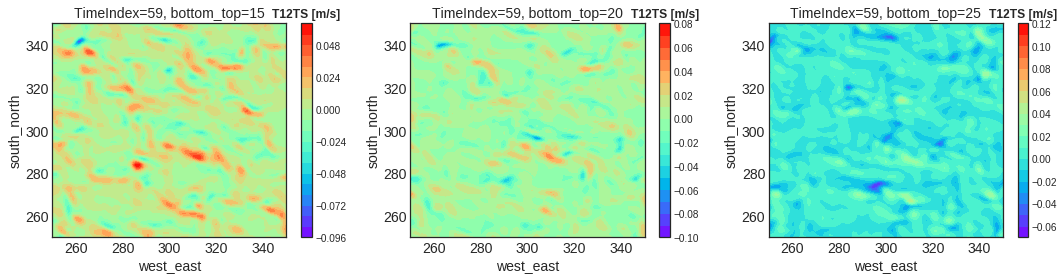

In [10]:
plane = ['xy','yz','xz']
qoi_list = ['UTS', 'TKETS', 'T12TS']

for qoi in qoi_list:
    qoi_data, qoi_dim_names, qoi_dim = getQoI(wrf_domain6, qoi)
    slt = sampling_loc_time(qoi_dim_names, qoi_dim)
    
    for plane_ind in range(0,1):
        pl = plane[plane_ind]
        if pl=='xy':
            plane_cols, plane_rows = np.meshgrid(wrf_domain6[qoi_dim_names[3]], wrf_domain6[qoi_dim_names[2]])
            contourPlot(qoi_data, qoi_dim_names[1],slt,plane_rows, plane_cols, pl)
        elif pl=='yz':
            plane_cols, plane_rows = np.meshgrid(wrf_domain6[qoi_dim_names[2]], wrf_domain6[qoi_dim_names[1]])
            contourPlot(qoi_data, qoi_dim_names[3],slt,plane_rows, plane_cols, pl)
        elif pl=='xz':
            plane_cols, plane_rows = np.meshgrid(wrf_domain6[qoi_dim_names[3]], wrf_domain6[qoi_dim_names[1]])
            contourPlot(qoi_data, qoi_dim_names[2],slt,plane_rows, plane_cols, pl)
    